# CycleGAN: Unpaired Image-to-Image Translation

## 0. Some setup before we begin...

In this folder, please run the following commands to create empty folders for logging:

```
mkdir checkpoints_cyclegan
mkdir samples_cyclegan
```

Also, make sure the unzipped dataset folder ```summer2winter_yosemite``` is in the same folder as this file.

## 1. Load and Visualize the Data 

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

# Some matplotlib settings
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["axes.grid"] = False
plt.rcParams["xtick.major.bottom"] = False
plt.rcParams["ytick.major.left"] = False

# Device Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Some training settings:
batch_size = 16
num_workers = 0

The dataset can be downloaded from the following [Link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

Move the ```summer2winter_yosemite``` folder into the git repo.

### Define function to generate train and test dataloaders

The following function returns train and test dataloaders, which we will use to visualize the data and train the model

In [2]:
def get_data_loaders(image_type, image_dir='summer2winter_yosemite', transform=None, batch_size=16, num_workers=0):
    
    # get training and test directories
    image_type_test = "test_{}".format(image_type)
    train_path = os.path.join(image_dir, image_type)
    test_path = os.path.join(image_dir, image_type_test)

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

Now we can call the functions to get two sets of dataloaders. 

But first, we must define a image transformation function to transform the images from PIL format to Tensor format.

We also normalize the image using standard mean and variances

transforms.Compose() takes a list of transformations and calls them in sequence. 

In [3]:
image_size = 256
transformations = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

summer_dataloader, test_summer_dataloader = get_data_loaders(image_type='summer', transform=transformations, 
                                                            batch_size=batch_size, num_workers=num_workers)
winter_dataloader, test_winter_dataloader = get_data_loaders(image_type='winter', transform=transformations,
                                                            batch_size=batch_size, num_workers=num_workers)

Dataset created by ```datasets.ImageFolder``` return two values: 

1. Image
2. corresponding label.

When we wrap a dataloader around the dataset, this becomes a batch of images, and the corresponding labels. 

In our case, we are not interested in the labels (they are all 0). Thus, to visualize the data, we only save the first term of the returned values. To iterate just one batch of the dataset, we wrap the dataloader as an iterable and call one iteration.


### Visualize the data 

We define an inverse transform that changes a tensor back to a PIL Image. First, we "unnormalize" the tensor by taking the inverse of the normalization function from above. Then, we can call ```transforms.ToPILImage()``` which will convert the tensor to a PIL Image

In [4]:
def get_pil_img_from_tensor(img_tensor):
    inverse_transform = transforms.Compose([transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5]), 
                                            transforms.ToPILImage()])
    return inverse_transform(img_tensor)

def show_img(pil_img):
    plt.imshow(pil_img)

In [5]:
batch_summer_imgs, _ = next(iter(summer_dataloader))
batch_winter_imgs, _ = next(iter(winter_dataloader))

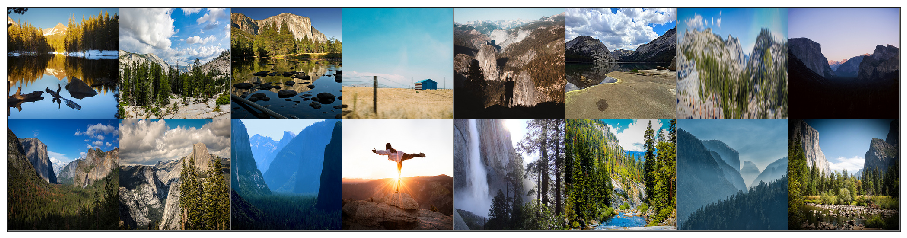

In [6]:
show_img(get_pil_img_from_tensor(torchvision.utils.make_grid(batch_summer_imgs)))

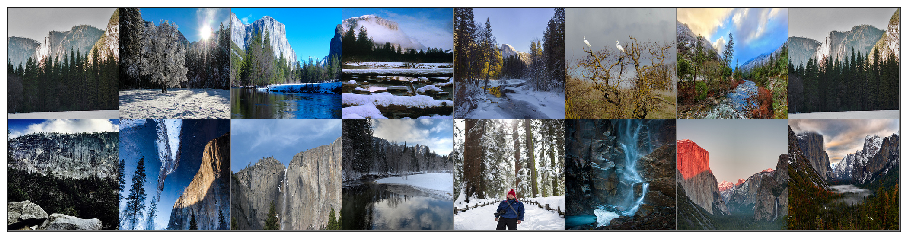

In [7]:
show_img(get_pil_img_from_tensor(torchvision.utils.make_grid(batch_winter_imgs)))

## 2. Define the Model 

### A function that creates a general convolution layer 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Discriminator

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))      #결과 size [16, 64, 64, 64]
        out = F.relu(self.conv2(out))    #[16, 128, 32, 32]
        out = F.relu(self.conv3(out))    #[16, 256, 16, 16]
        out = F.relu(self.conv4(out))    #[16, 512, 8, 8]
        out = self.conv5(out)            #[16, 1, 7, 7]
        return out

### Functions for the Generator

In [10]:
# residual block class
class ResidualBlock(nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
            
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Generator

In [11]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # Encoder 
        
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # Resnet part
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Decoder
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)  # no batch norm on last layer
        
    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))           # tanh applied to last layer

        return out

### Model Creator 

In [12]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6, device='cuda'):
    
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # Cast to appropriate device. 
    G_XtoY.to(device)
    G_YtoX.to(device)
    D_X.to(device)
    D_Y.to(device)
    print('Models loaded on {}'.format(device))

    return G_XtoY, G_YtoX, D_X, D_Y

In [13]:
G_XtoY, G_YtoX, D_X, D_Y = create_model(device=device)

Models loaded on cuda


#### At this point, you can open a terminal on the server and run ```nvidia-smi```. On the first GPU, you will see that some memory has been allocated for your model (~1GB). 

If you want to skip training and just visualize samples, skip to Section 6

## 3. Loss functions 

We can use the ```MSELoss()``` and ```L1Loss()``` defined in ```torch.nn``` for our loss functions.

In [ ]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss

## 4. Optimizers 

- We will use Adam with a initial learning rate of ```lr=0.0002```. 

- In PyTorch, we pass the model's parameters into the optimizer. The model's parameters can be obtained by calling ```model.parameters()```. 

- When we want to optimize the parameters of two models with one optimizer, we can simply concatenate the list of the two models' parameters and pass that into the optimizer 

In [ ]:
import torch.optim as optim

# Hyperparameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_x_optimizer = optim.Adam(params=D_X.parameters(), lr=lr, betas=[beta1, beta2])
d_y_optimizer = optim.Adam(params=D_Y.parameters(), lr=lr, betas=[beta1, beta2])

generator_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())
g_optimizer = optim.Adam(params=generator_params, lr=lr, betas=[beta1, beta2])

## 5. Training 

### Training Loop 

Skip this part if you want to skip directly to visualizing the results with a pretrained network.

Training takes around **80 minutes** on a single **NVIDIA 2080Ti** GPU (CUDA 10.2). It will use up around **7GB** of VRAM

In [ ]:
import time
from helpers import save_samples, checkpoint

In [ ]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    since = time.time()
    print_every=100
    sample_every=100
    
    losses = []      # keep track of losses over time

    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    # Generate true and false labels
    real_label = torch.ones(batch_size, requires_grad=False).to(device)
    fake_label = torch.zeros(batch_size, requires_grad=False).to(device)

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_Y, _ = iter_Y.next()
        
        # move images to device
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        """D_X """ 
        
        d_x_optimizer.zero_grad()

        # Train with real X images
        
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake X images
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X.detach())
        D_X_fake_loss = fake_mse_loss(out_x)
        
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        """D_Y """ 
        
        d_y_optimizer.zero_grad()
        
        # Train with real Y images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake Y images
        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y.detach())
        D_Y_fake_loss = fake_mse_loss(out_y)

        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        """G : G_XtoY + G_YtoX """ 
        

        g_optimizer.zero_grad()
        
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)
        
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        # Print
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            time_elapsed = time.time() - since
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f} time : {:.0f}m {:.0f}s'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item(),time_elapsed // 60, time_elapsed % 60))

        
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan')
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every=1
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [ ]:
n_epochs = 6000 # keep this small when testing if a model first works

losses = training_loop(summer_dataloader, winter_dataloader, test_summer_dataloader, test_winter_dataloader, n_epochs=n_epochs)

### Visualize Training Losses

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## 6. Visualize the Results 

### (Optional) Load Pretrained Models

If we lack the time and resources to fully train the model, we can load a pretrained model and visualize the results. Use the ```save_samples``` function as in the training loop

In [14]:
from helpers import load_checkpoints
load_checkpoints(G_XtoY, G_YtoX, D_X, D_Y)

### Visualize Samples 

In [15]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

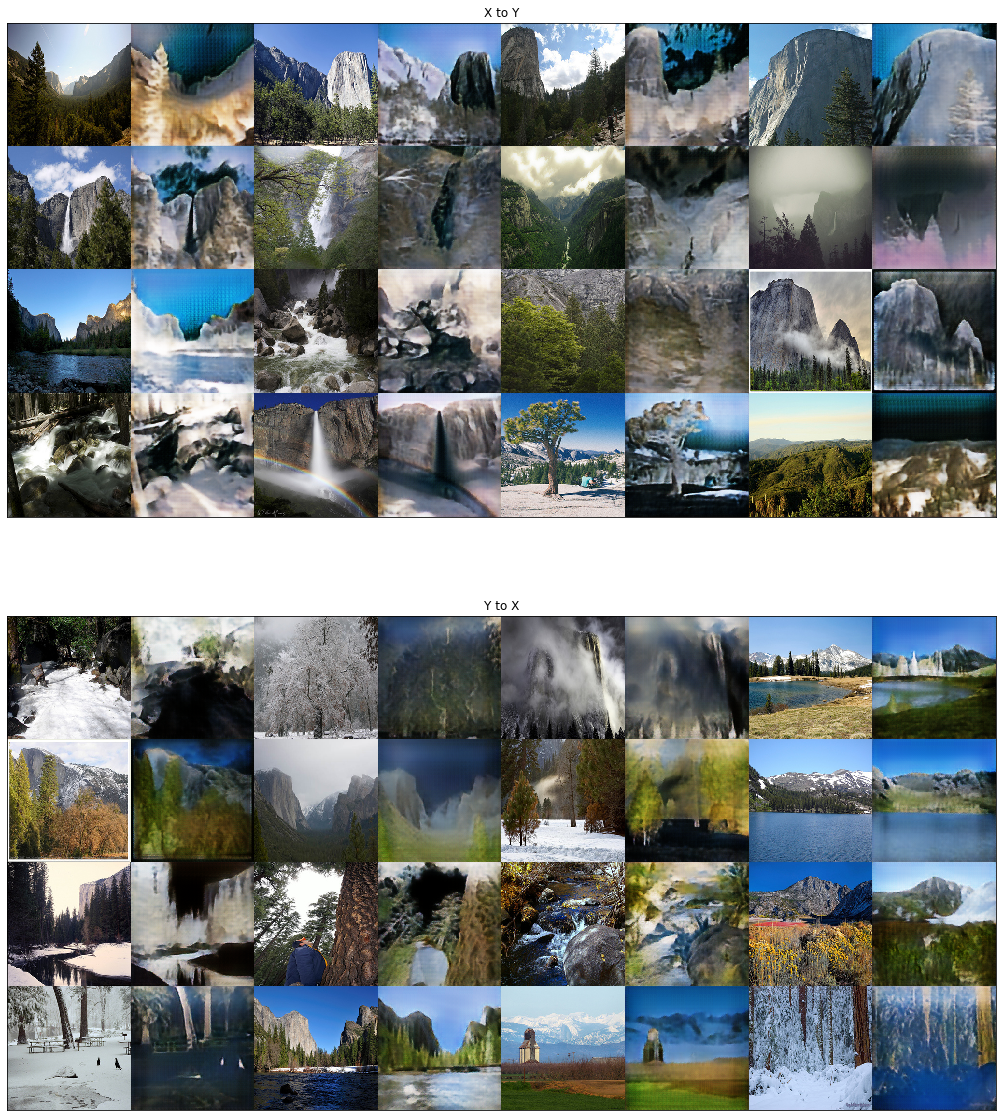

In [16]:
# view samples at iteration 100
view_samples(6000, 'samples_cyclegan')

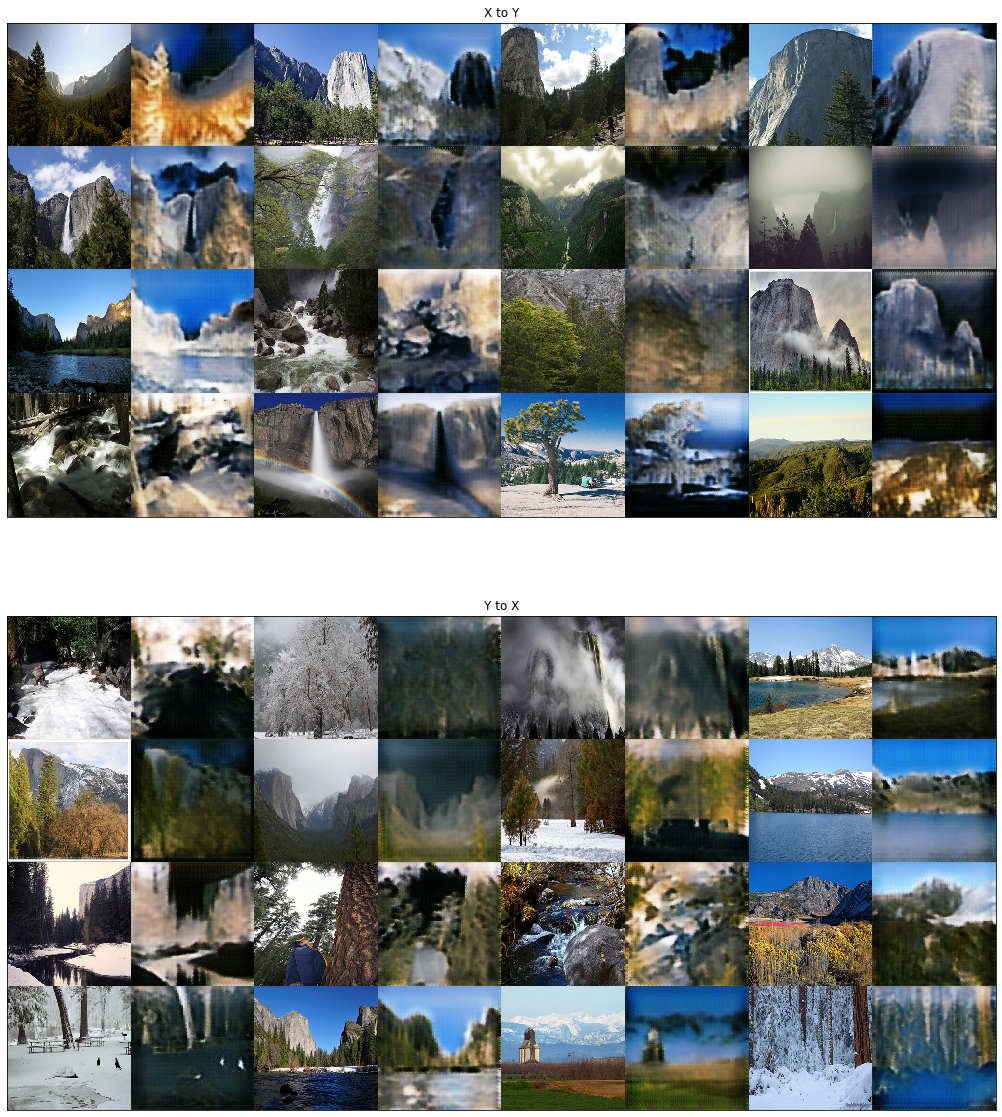

In [17]:
view_samples(1000, 'samples_cyclegan')